# node2vecで企業ネットワークを埋め込み

In [3]:
import networkx as nx

graphml_file = 'data/kanagawa_yakuin.graphml'

# GraphMLファイルの読み込み
G = nx.read_graphml(graphml_file)

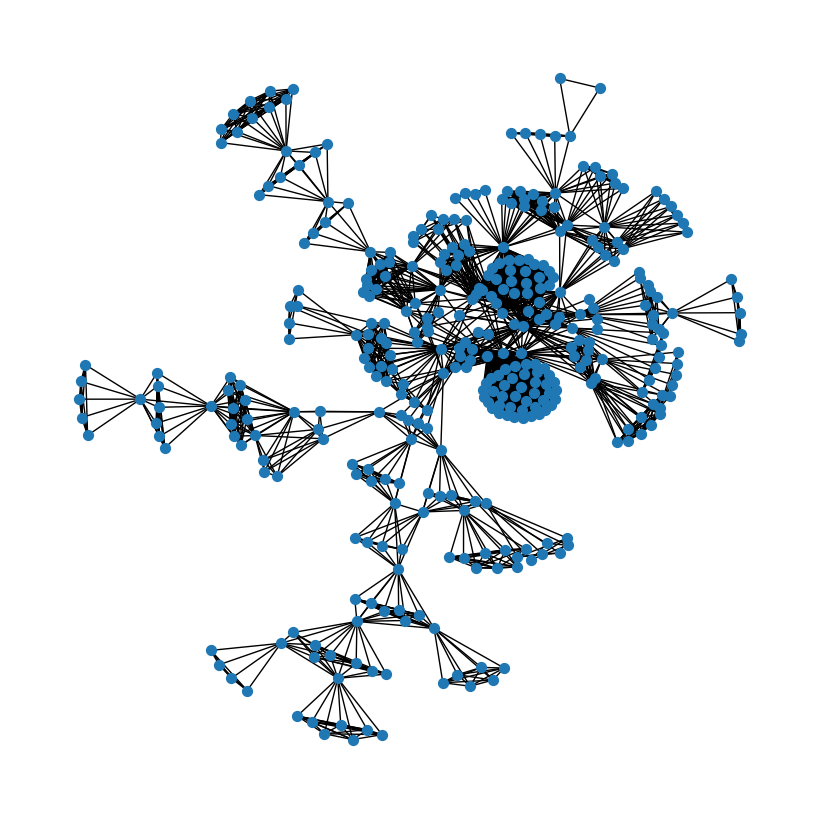

In [4]:
# 可視化
# graphvizバージョン
import matplotlib.pyplot as plt

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=nx.nx_pydot.graphviz_layout(G_draw), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

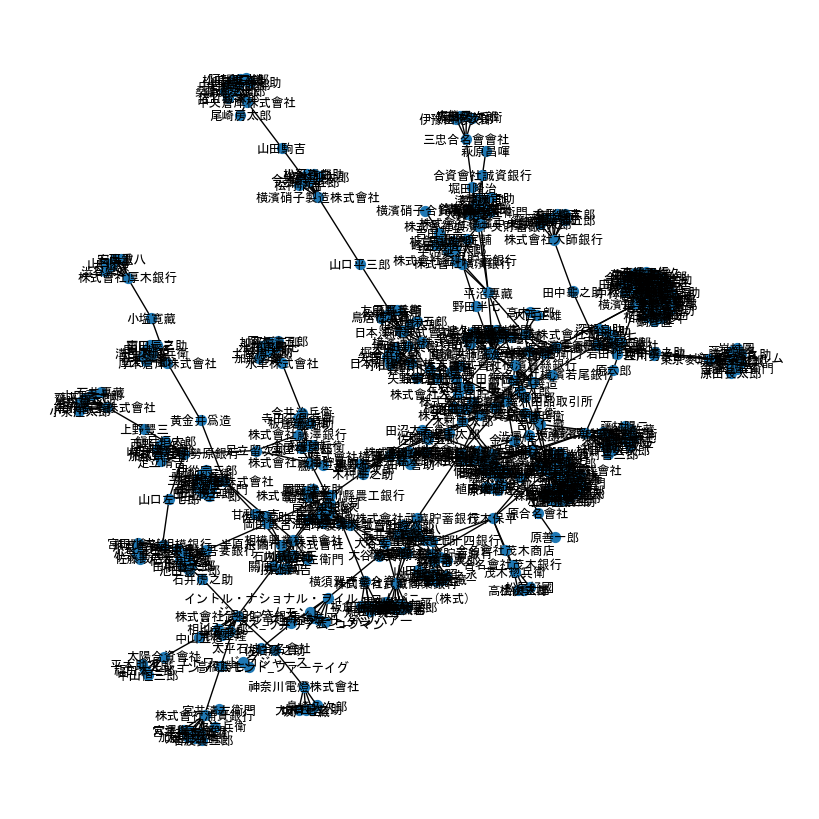

In [2]:
# 可視化
# graphvizを使わないバージョン
import matplotlib.pyplot as plt

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, with_labels=True, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

Node2Vec

In [125]:
# 最大連結成分だけ使う
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

In [126]:
# PyG (PyTorch Geometric)で使える形式に変換
import torch
from torch_geometric.data import Data

# ノードに数値IDを割り当てる（日本語を数値に変換）
mapping = {node: i for i, node in enumerate(G.nodes())}
G_num = nx.relabel_nodes(G, mapping)

# PyGはエッジリストを (2, num_edges) 形式で要求するため、エッジを転置
edge_index = torch.tensor(list(G_num.edges), dtype=torch.long).t().contiguous()

# ノードの特徴量（例として、すべてのノードに特徴量1を設定）
x = torch.ones((G_num.number_of_nodes(), 1))

# PyGのデータ形式に変換
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[441, 1], edge_index=[2, 515])


In [211]:
# モデルの作成
import torch
from torch_geometric.nn import Node2Vec

# GPUが利用可能な場合はGPUを使用し、そうでない場合はCPUを使用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=4,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [18]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

Epoch: 000, Loss: 1.2382
Epoch: 001, Loss: 1.2023
Epoch: 002, Loss: 1.1746
Epoch: 003, Loss: 1.1420
Epoch: 004, Loss: 1.1162
Epoch: 005, Loss: 1.0894
Epoch: 006, Loss: 1.0651
Epoch: 007, Loss: 1.0472
Epoch: 008, Loss: 1.0319
Epoch: 009, Loss: 1.0118
Epoch: 010, Loss: 0.9954
Epoch: 011, Loss: 0.9806
Epoch: 012, Loss: 0.9670
Epoch: 013, Loss: 0.9541
Epoch: 014, Loss: 0.9504
Epoch: 015, Loss: 0.9419
Epoch: 016, Loss: 0.9299
Epoch: 017, Loss: 0.9193
Epoch: 018, Loss: 0.9167
Epoch: 019, Loss: 0.9059
Epoch: 020, Loss: 0.9019
Epoch: 021, Loss: 0.8973
Epoch: 022, Loss: 0.8929
Epoch: 023, Loss: 0.8889
Epoch: 024, Loss: 0.8833
Epoch: 025, Loss: 0.8767
Epoch: 026, Loss: 0.8724
Epoch: 027, Loss: 0.8708
Epoch: 028, Loss: 0.8678
Epoch: 029, Loss: 0.8628
Epoch: 030, Loss: 0.8620
Epoch: 031, Loss: 0.8574
Epoch: 032, Loss: 0.8557
Epoch: 033, Loss: 0.8539
Epoch: 034, Loss: 0.8536
Epoch: 035, Loss: 0.8514
Epoch: 036, Loss: 0.8456
Epoch: 037, Loss: 0.8463
Epoch: 038, Loss: 0.8440
Epoch: 039, Loss: 0.8415


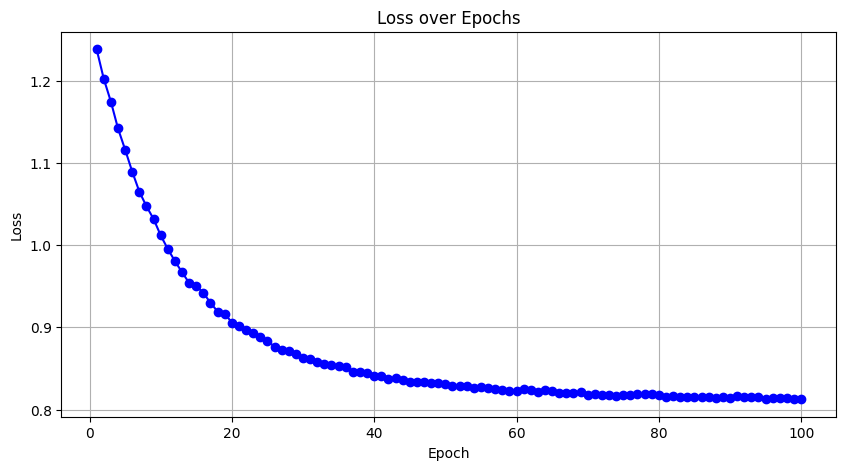

In [212]:
# 学習

# 学習時の損失値を記録するためのリスト
losses = []

num_epochs = 100
for epoch in range(num_epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# 損失値の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 埋め込みの可視化

In [20]:
# 描画する関数
def plot_points(z, node_labels=None):
    """
        z: 埋め込み
        node_labels: G.nodesを指定すればOK 何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))
    plt.scatter(z[:, 0], z[:, 1], s=70, color='b', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")

    plt.axis('off')
    plt.show()

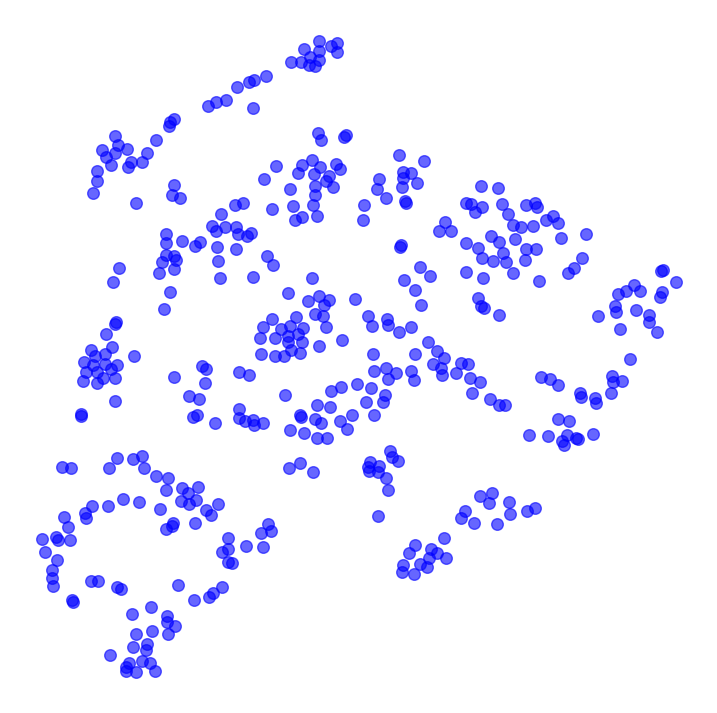

In [213]:
# TSNEを使うパターン
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    plot_points(z)

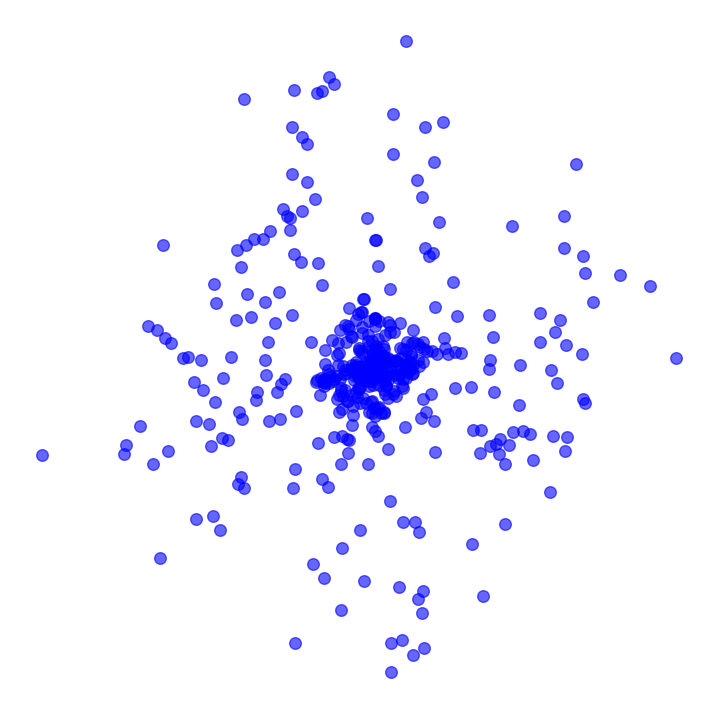

In [214]:
# PCAを使うパターン
from sklearn.decomposition import PCA

model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = PCA(n_components=2).fit_transform(z)
    plot_points(z)

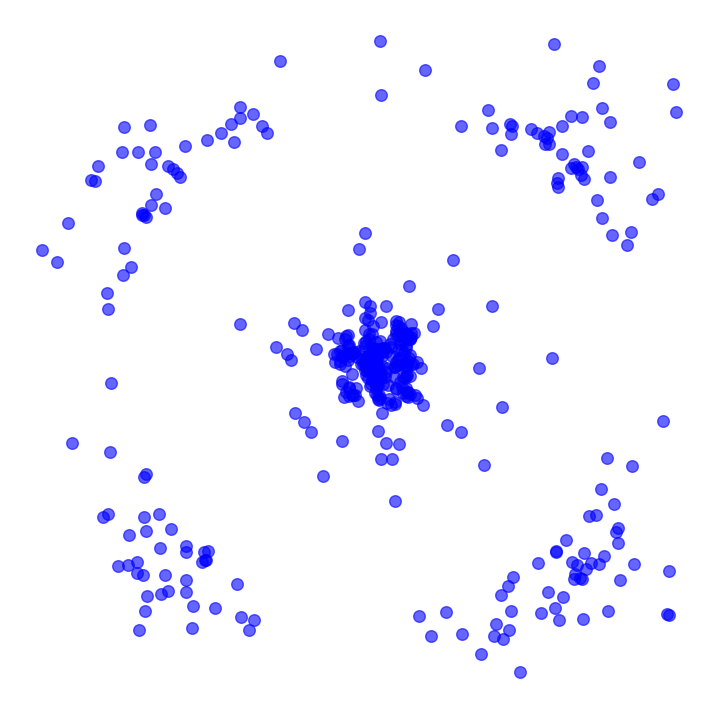

In [192]:
# 2次元の埋め込み
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    plot_points(z)

## kmeansでクラスタリング

In [215]:
from sklearn.cluster import KMeans

# 埋め込み表現
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(z)

KMeans(n_clusters=5, random_state=42)

In [194]:
# クラスタリングを可視化

def plot_clustering(z, colors, n_clusters):
    y = kmeans.labels_

    plt.figure(figsize=(8, 8))
    for i in range(n_clusters):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i], label=f'Cluster {i}')
    plt.axis('off')
    plt.legend(title='Clusters')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#ff0000', '#ffd700', "#008000"
]

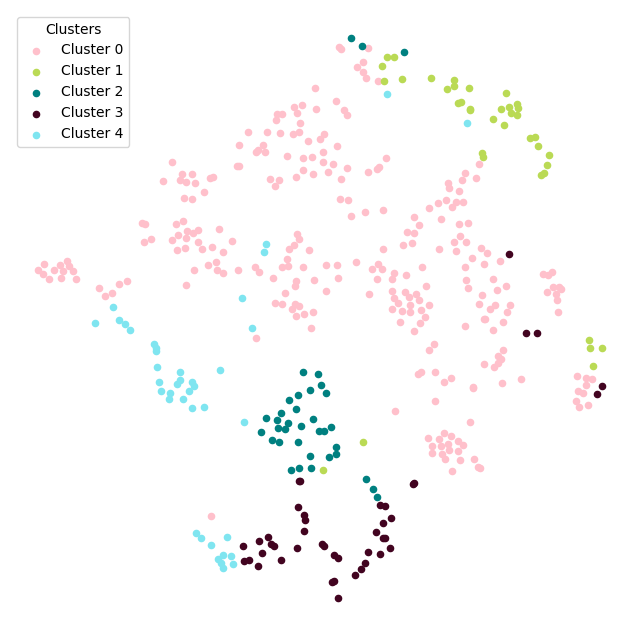

In [216]:
# TSNEを使う場合
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    plot_clustering(z, colors, n_clusters)

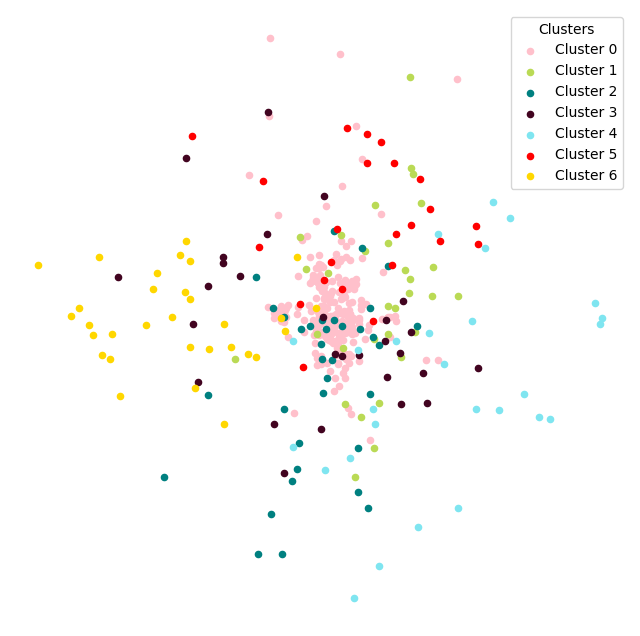

In [182]:
# PCAを使う場合
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    z = PCA(n_components=2).fit_transform(z)
    plot_clustering(z, colors, n_clusters)

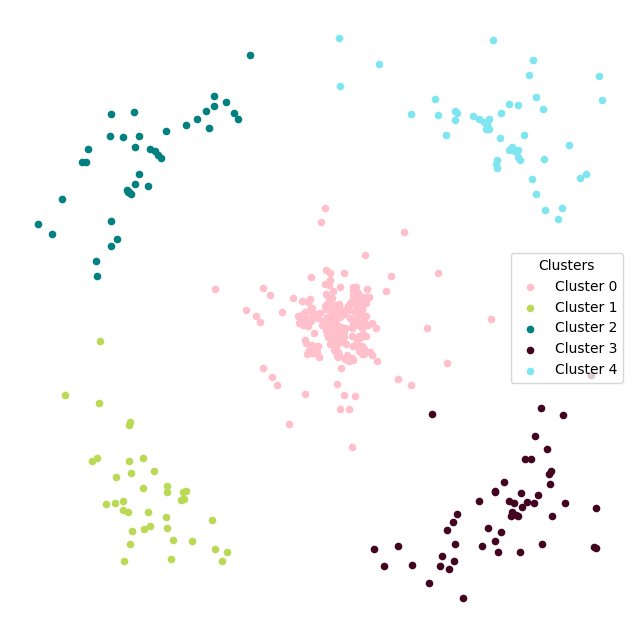

In [209]:
# 2次元の埋め込みの場合
model.eval()
with torch.no_grad():
    z = model().cpu().numpy()
    plot_clustering(z, colors, n_clusters)

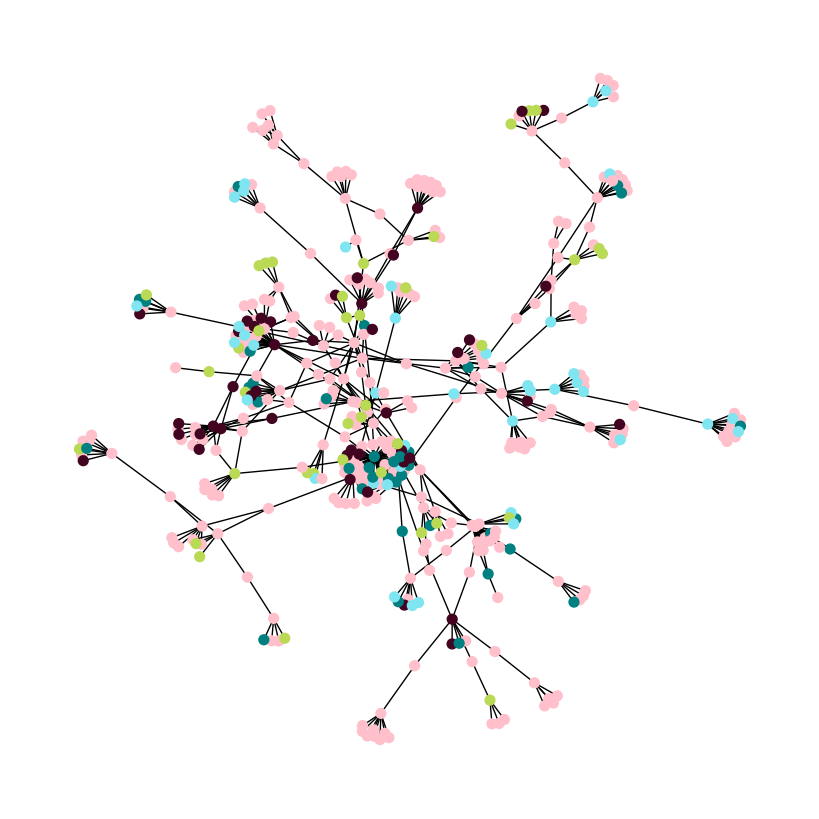

In [218]:
# ネットワークでクラスタリングを可視化
# graphvizバージョン
import matplotlib.pyplot as plt

G_draw = G

# グラフ描画
# 上の埋め込みのクラスタ描画と色を一致させる
node_colors = [colors[label % len(colors)] for label in kmeans.labels_]

plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        # pos=nx.nx_pydot.graphviz_layout(G_draw),
        with_labels=False,
        font_family="MS Gothic",
        node_size=50,
        font_size=9,
		node_color=node_colors
		)
plt.show()


In [205]:
# ノードとクラスタラベルのペアをデータフレームに作成
import pandas as pd

df_clusters = pd.DataFrame({
    'Node': G.nodes,
    'Cluster': kmeans.labels_
})

In [219]:
df_clusters[df_clusters["Cluster"] == 0]

,Node,Cluster
0,横濱魚油株式會社,0
1,榊原龜丸,0
2,太田貞一,0
3,西野祐次郎,0
4,脇庄三郎,0
...,...,...
427,齋藤權三郎,0
428,穴澤與十郎,0
429,黒部與八,0
434,持田初治郎,0


In [182]:
df_clusters[df_clusters["Node"] == "若尾幾造"]

,Node,Cluster
246,若尾幾造,6


## Louvain法でクラスタリング

In [186]:
import community as community_louvain

# Louvain法によるクラスタリング
partition = community_louvain.best_partition(G)

partition

{'横濱魚油株式會社': 0,
 '榊原龜丸': 1,
 '太田貞一': 2,
 '西野祐次郎': 3,
 '脇庄三郎': 4,
 '株式會社横濱蠶絲外四品取引所': 16,
 '中村錠太郎': 6,
 '田中林藏': 0,
 '守谷此助': 7,
 '小島吉左衛門': 8,
 '松田金三郎': 9,
 '中井芳楠': 6,
 '高辻高': 1,
 '古川謙': 10,
 '鈴木卯三郎': 11,
 '齋藤喜三郎': 3,
 '植田鐘三郎': 12,
 '株式會社横濱中央銀行': 2,
 '原善一郎': 13,
 '萩野誠一': 14,
 '大友政之丞': 13,
 '靑木鐡太郎': 6,
 '株式會社横濱七十四銀行': 1,
 '岩村圓': 7,
 '堀田梅吉': 14,
 '土子金四郎': 13,
 '小野政吉': 6,
 '深瀬良助': 7,
 '永井由藏': 14,
 '今井治兵衛': 14,
 '三崎龜之助': 6,
 '早川平四郎': 13,
 '伊藤鏆太郎': 12,
 '菊池忠三郎': 6,
 '齋藤満平': 4,
 '前田又平': 0,
 '山井景美': 13,
 '株式會社第二銀行': 11,
 '林政敏': 6,
 '合名會社横濱若尾銀行': 16,
 '松村清吉': 12,
 '板倉喜太郎': 16,
 '佐藤明次郎': 1,
 '佐伯藤之助': 5,
 '株式會社相模銀行': 3,
 '關原久吉': 8,
 '田邊幸七': 16,
 '大熊又一': 2,
 'エドウ井ン_ダン': 1,
 '梅原良': 3,
 '神崎正兵衛': 8,
 '峰田淸造': 16,
 '藤林忠兵衛': 2,
 '原田久吉': 0,
 '高橋勝七': 5,
 '佐藤政吉': 3,
 '朝田又七': 12,
 '厚木倉庫株式會社': 10,
 '岩田俊平': 3,
 '高橋正信': 6,
 '森宗助': 15,
 '株式會社武藏貯蓄銀行': 1,
 '太田又四郎': 5,
 '臼井儀兵衛': 5,
 '近藤與十': 1,
 '服部泰次郎': 1,
 '中山五造': 5,
 '原木仙之助': 12,
 '伊東小三郎': 6,
 '三橋泰次郎': 8,
 '櫻井權太郎': 7,
 '株式會社横濱實業銀行': 12,
 '大谷金藏': 1,
 '霜田語吉': 7,
 '間宮

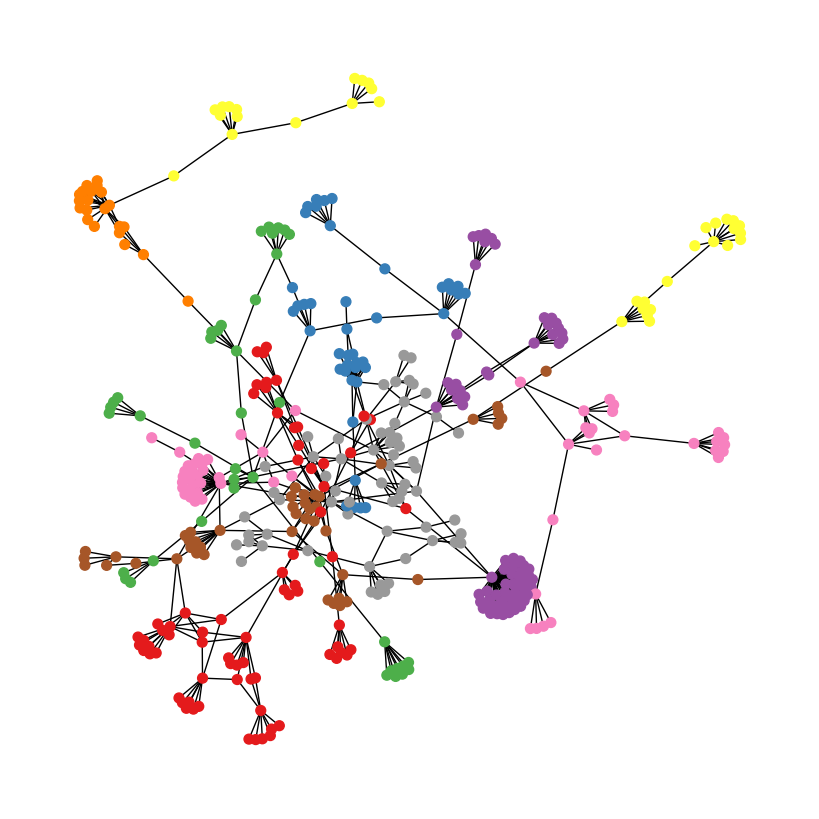

In [187]:
# 結果を描画
# クラスタ数が多いと色が重複する

G_draw = G

plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        # pos=nx.nx_pydot.graphviz_layout(G_draw),
        with_labels=False,
        font_family="MS Gothic",
        node_size=50,
        font_size=9,
		cmap=plt.get_cmap('Set1'), # 9色しかない
		node_color=[partition[node] for node in G.nodes()]
		)
plt.show()